# Simulation of Decision making in the Medical domain

participants need to make 84 selection between slight improvement (level 1) for sure</br> 
or a chance for a moderate (level 2)</br>
significant (level 3)</br>
or complete recovery (level 4). </br>
However, each alternative treatment can result in complete paralysis (level 0).

In order to asses participant behavior I will try to compare 2 models:</br>
   1. a relation between the levels. Base on the formula y = x^b + a</br>
        in this formula a is the intercept and b is the slope.</br>
        slope = 1 will result in a linear correlation between the levels</br>
        slope < 1 will result in a concave relation, each improvement has less value</br>
        slope > 1 will result in an exponential slope, each improvement has higher value
        
   2. model 2 will assume only a monotonic relation with each level bigger than the other.</br>
        data inference from this model is less productive but it should have a good fit

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy.special import expit
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az
import cmdstanpy

import matplotlib.pyplot as plt
import seaborn as sns

## Load the data and add the levels

In [2]:
db = pd.read_csv('data/sim.csv')
db['med']= np.where(db["value"] == 5, 1, 
                    np.where(db["value"] == 8, 2,
                            np.where(db["value"] == 12, 3, 4)))
db.head()                      

,Unnamed: 0,value,risk,ambiguity,med
0,0,5,0.25,0.00,1
1,1,5,0.50,0.50,1
2,2,12,0.50,0.74,3
3,3,25,0.50,0.74,4
4,4,8,0.50,0.50,2


## Simulate the data base on the formula of the first  model

In [34]:
n_subs = 50 # number of subs

α_true = np.random.beta(2, 4, n_subs) # the real alpha value, drown from a beta distribution 
α_true = α_true * 2 # times 2, as alpha can range from 0 to 2. average ~ 0.65
β_true = stats.truncnorm.rvs(-1.5, 1.5, 0.3, size = n_subs) # draw a beta from a turncate normal disterbution

# create values for medical decision
med_int = np.random.uniform(1,10,n_subs) # draw a random number participant value option 1
med_slp = np.random.gamma(1,1,n_subs) # draw a slope between 0 (concave) and 10 (exp)

# create an array 84 by number of participants
refValue = np.array([y for x in med_int for y in (x,) * db.shape[0]])
slope = np.array([y for x in med_slp for y in (x,) * db.shape[0]])

# calculate percieved value
value_per = refValue + np.tile(db.med,      n_subs) ** slope

# get values for the model
value     = np.tile(np.array(db.med),       n_subs) # the levels (1-4)
risk      = np.tile(np.array(db.risk),      n_subs) # risk levels (0.25, 0.5, 0.75)
ambiguity = np.tile(np.array(db.ambiguity), n_subs) # ambiguity levels (0, 0.24, 0.5, 0.74)

# ref values 
refProbabilities = np.tile(1, len(value))
refAmbiguities   = np.tile(0,   len(value))


riskTol = np.repeat(α_true, len(risk) / n_subs)
ambTol  = np.repeat(β_true, len(ambiguity) / n_subs)

<AxesSubplot:ylabel='Count'>

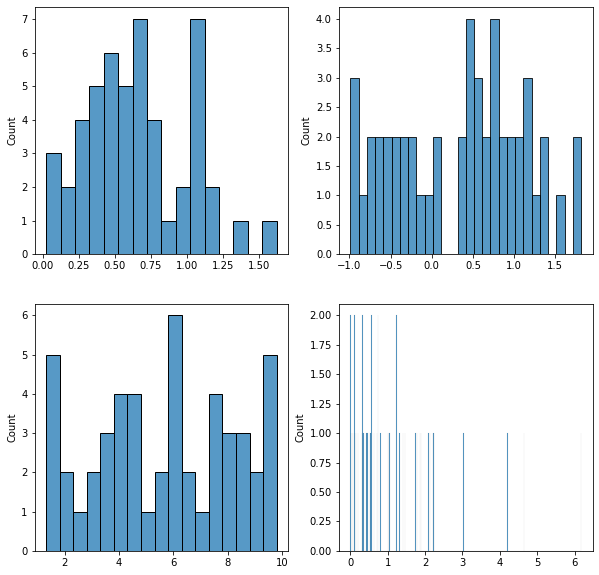

In [35]:
f, ax = plt.subplots(2,2, figsize=(10, 10))
sns.histplot(α_true, binwidth=0.1,ax=ax[0,0])
sns.histplot(β_true, binwidth=0.1,ax=ax[0,1])
sns.histplot(med_int, binwidth=0.5,ax=ax[1,0])
sns.histplot(med_slp, binwidth=0.01,ax=ax[1,1])

## Calculate probability and make choices 

In [36]:
uRef = refValue ** riskTol
uLotto = (value_per ** riskTol) * (risk - (ambTol * ambiguity / 2))
p = sp.special.expit(uLotto - uRef)

choice = np.random.binomial(1, p, len(p))

In [37]:
sub_idx = np.arange(n_subs)
sub_idx = np.repeat(sub_idx, db.shape[0])
ID = sub_idx+1
n_trials = np.arange(len(choice))

simdata = pd.DataFrame({'sub': ID, 'choice': choice, 'value': value, 'risk': risk, 'ambiguity': ambiguity, 'riskTol': riskTol, 'ambTol': ambTol})
simdata.head()

,sub,choice,value,risk,ambiguity,riskTol,ambTol
0,1,0,1,0.25,0.00,0.627719,-0.98811
1,1,1,1,0.50,0.50,0.627719,-0.98811
2,1,1,3,0.50,0.74,0.627719,-0.98811
3,1,1,4,0.50,0.74,0.627719,-0.98811
4,1,1,2,0.50,0.50,0.627719,-0.98811


In [44]:
with pm.Model() as RiskAmb_Beta:
    # Hyper Priors
    alpha_a = pm.Poisson('alpha_a', 3)
    alpha_b = pm.Poisson('alpha_b', 3)
    
    bMu = pm.Beta('bMu', 1,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
   
    med_slope = pm.Gamma('med_slope', 1, 1, shape = n_subs)
    med_intercept = pm.Uniform('med_intercept', 1, 10, shape = n_subs)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    val = (med_intercept[sub_idx] + simdata['value'].values ** med_slope[sub_idx]) ** α[sub_idx]
    svLotto = val * (simdata['risk'].values - (β[sub_idx] * (simdata['ambiguity'].values/2)))
    svRef = med_intercept[sub_idx] ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=simdata['choice'])
    trace_beta = pm.sample(5000, return_inferencedata=True, nuts={'target_accept':0.99})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha_b]
>>Metropolis: [alpha_a]
>NUTS: [γ, β, alpha, med_intercept, med_slope, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5094 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>],
       [<AxesSubplot:title={'center':'med_intercept'}>,
        <AxesSubplot:title={'center':'med_intercept'}>],
       [<AxesSubplot:title={'center':'med_slope'}>,
        <AxesSubplot:title={'center':'med_slope'}>]], dtype=object)

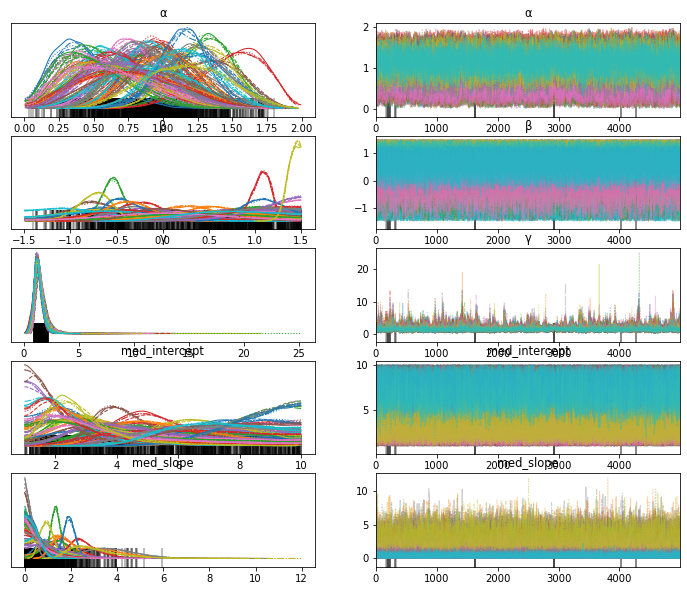

In [45]:
az.plot_trace(trace_beta, var_names=['α','β','γ','med_intercept','med_slope'])

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


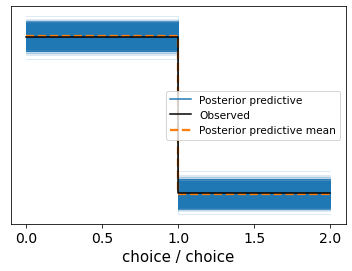

In [46]:
with RiskAmb_Beta:   
            ppc = pm.sample_posterior_predictive(trace_beta)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb_Beta))

In [48]:
df = simdata
subs = df['sub'].unique()

α_pymc = az.summary(trace_beta, var_names=['α'])['mean']
β_pymc = az.summary(trace_beta, var_names=['β'])['mean']
mi_pymc = az.summary(trace_beta, var_names=['med_intercept'])['mean']
ms_pymc = az.summary(trace_beta, var_names=['med_slope'])['mean']

outcome = pd.DataFrame({'subs':subs,
                        'α_true': α_true,  'α_pymc': α_pymc.values,
                        'β_true': β_true,  'β_pymc': β_pymc.values, 
                        'mint_true': med_int, 'mint_pymc': mi_pymc.values,
                        'mslope_true': med_slp, 'mslope_pymc': ms_pymc.values})

outcome.corr()

,subs,α_true,α_pymc,β_true,β_pymc,mint_true,mint_pymc,mslope_true,mslope_pymc
subs,1.000000,0.074510,0.058147,0.253384,0.232032,-0.113271,-0.130569,-0.132263,-0.032464
α_true,0.074510,1.000000,0.804109,0.006399,-0.177355,-0.037269,0.360561,-0.001610,0.320229
α_pymc,0.058147,0.804109,1.000000,-0.005938,-0.077697,0.269952,0.409534,0.242567,0.391531
β_true,0.253384,0.006399,-0.005938,1.000000,0.785354,-0.005870,0.069926,0.039023,-0.002594
β_pymc,0.232032,-0.177355,-0.077697,0.785354,1.000000,0.088797,-0.111650,0.052214,0.009987
mint_true,-0.113271,-0.037269,0.269952,-0.005870,0.088797,1.000000,0.665252,0.100426,-0.102383
mint_pymc,-0.130569,0.360561,0.409534,0.069926,-0.111650,0.665252,1.000000,-0.203727,-0.211127
mslope_true,-0.132263,-0.001610,0.242567,0.039023,0.052214,0.100426,-0.203727,1.000000,0.776201
mslope_pymc,-0.032464,0.320229,0.391531,-0.002594,0.009987,-0.102383,-0.211127,0.776201,1.000000


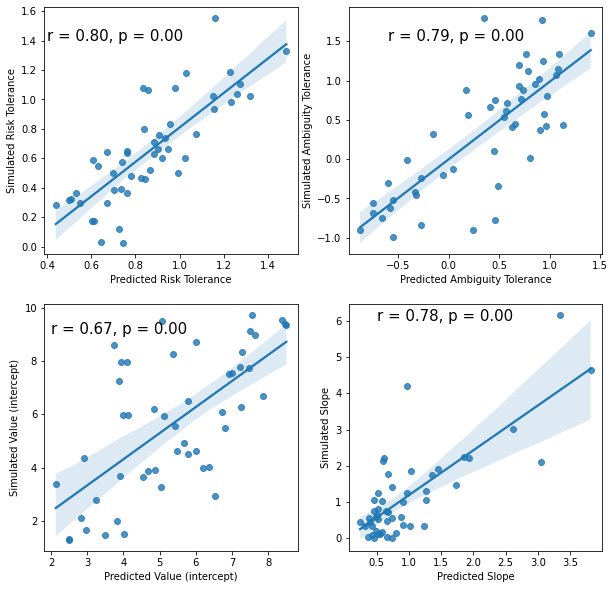

In [49]:
f, ax = plt.subplots(2,2, figsize=(10, 10))

sns.regplot(x = 'α_pymc',      y = 'α_true',       data = outcome, ax=ax[0,0])
sns.regplot(x = 'β_pymc',      y = 'β_true',       data = outcome, ax=ax[0,1])
sns.regplot(x = 'mint_pymc',   y = 'mint_true',    data = outcome, ax=ax[1,0])
sns.regplot(x = 'mslope_pymc', y = 'mslope_true',  data = outcome, ax=ax[1,1])


ax[0,0].set(xlabel='Predicted Risk Tolerance',      ylabel='Simulated Risk Tolerance')
ax[0,1].set(xlabel='Predicted Ambiguity Tolerance', ylabel='Simulated Ambiguity Tolerance')
ax[1,0].set(xlabel='Predicted Value (intercept)',   ylabel='Simulated Value (intercept)')
ax[1,1].set(xlabel='Predicted Slope',               ylabel='Simulated Slope')

corr = (sp.stats.pearsonr(outcome.α_pymc, outcome.α_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,0].text(.4, 1.4, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome.β_pymc, outcome.β_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,1].text(-.6, 1.5, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome.mint_pymc, outcome.mint_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,0].text(2, 9, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome.mslope_pymc, outcome.mslope_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,1].text(.5, 6, text, fontsize=15)

plt.show()